# Article Review & Reproduction

This notebook is a work due for Pr. Nelly Pustelnik's machine learning class of the M2 complex systems at ENS Lyon. In the following we review an article introducing physics-informed neural networks and reproduce some of its results.

**Students**: Ayoub Dhibi & Théodore Farmachidi

**Article**:
[Maziar Raissi, , Paris Perdikaris, George Em Karniadakis. "Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations." (2017).](https://arxiv.org/abs/1711.10561)

**Note**: the presentation is expected to include a general introduction, the article's specific features in relation to the state of the art, a more technical section on the article's contributions, and a presentation of the results reproduced.

---

## Table of Contents
1. [Article Summary](#article-summary)
2. [Key Concepts & Methods](#key-concepts--methods)
3. [Reproduction of Results](#reproduction-of-results)

---

**Roadmap**:

1. Review the article, explain each part
2. Reproduce examples
3. Apply the method to a new use case
4. Prepare the presentation (10' presentation + 10' questions)

**Due dates**: 
- ML challenge for the 04/01
- notebook for the 05/01
- presentation for the 09/01

## 1. Article Summary <a id="article-summary"></a>
This part reformulate each section of the article and explains technical details.

### 1. Introduction
Neural networks (NNs) are efficient to solve many machine learning (ML) problems:
- natural language processing
- image recognition
- ...

However to be efficient they require a lot of data which in practical setup is rarely available. Especially for complex systems:
- biological systems
- social systems
- complex physical systems
- ...

The current approach is to train the NN using data training pairs (data point, target to be predicted). The network is adjusted until minimizes an error function that quantifies the distance between the predicted output and the training target. The error function can encompass a regularization term that limits overfitting on the training data. The resulting NN is an approximation of the true function (up to noise) that generated the training data. However this method do not make use of all the prior knowledge of the system. 
Physics-informed neural networks (PINNs) encode directly the physical constraints into the regularization. The resulting model, offers better convergence and better generalization even with few training data points available.

Previous work on physics-informed models used Gaussian process regression to solve linear problems. They got good approximations and theoretical error boundaries on different linear mathematical physics problems. Further works extended the models to non linear problems by using local linear approximations. The model applicability is thus restricted to discrete-time domains and specific non linear problems (e.g. no strong non linearities).

#### 1.1 Problem setup and summary of contributions
Deep neural networks are used as **universal** function approximators. 
Automatic differentiation is used to compute partial derivatives of the approximator function (= the NN) efficiently. These partial derivatives are then used during training to regularize the NN into physical constraints encoded in partial differential equations (PDEs) that the approximator must satisfy.
The PDEs encode all the physical laws characteristic of the system (conservation principles, symmetries, etc). This new approach lead to a new class of numerical solvers for PDEs and data-driven model inference.

This new approach can be used to tackle two types of problems:
1. data-driven solution: given training data sampling initial and boundary conditions find a function that is solution to the PDEs 
2. data-driven discovery: given training data sampling the solution over all the domain find the parameters of the PDEs ruling the physics in the domain

We can frame these as follow, lets consider parametrized non linear partial differential equations of the general form:
$$
\partial_t u(t,x) + \mathcal{N}[u;\lambda] = 0
$$
where $u(t,x)$ is the solution of the PDE and $\mathcal{N}[.;\lambda]$ is a non linear operator parametrized by $\lambda$.

Let us introduce the following notations of subscripts as partial derivatives:
$$
\partial_t u=u_t, \ \partial_x u=u_x, \ \partial_x^2 u=u_{xx}, \ \ldots
$$

For example Burger's equation writes:
$$
u_t + \lambda_1 uu_x - \lambda_2 uu_x = 0
$$
For this equation, $\mathcal{N}[u;\lambda] = \lambda_1 uu_x - \lambda_2 uu_x$ with $\lambda = (\lambda_1, \lambda_2)$.

The article focuses on **data-driven solutions** to the restricted class of problems:
$$
u_t + \mathcal{N}[u] = 0, \ x \in \Omega, \ t \in [0,T]
$$
with $\Omega$ a subset of $\mathbb{R}^D$.

The article presents two classes of algorithms, continuous and discrete time models and evaluate their properties and performance on benchmark problems. For reproducibility the authors made the code available at [https://github.com/maziarraissi/PINNs](https://github.com/maziarraissi/PINNs).

### 2. Continuous Time Models
A deep neural network is used to approximate a solution to the PDE. If the network is deep enough it is an universal approximator i.e. it can approximate any function one will ever encounter (except very pathological examples) [ref](https://www.sciencedirect.com/science/article/pii/0893608089900208). We denote the NN as $u^\theta$ where $\theta$ represents the network's parameters. Finally we define the *physics informed neural network*
$$
f = u_t^\theta + \mathcal{N}[u^\theta]
$$

Which can be derived via automatic differentiation. Automatic differentiation is a way to compute exact derivatives of numerical functions that are expressed as computational graphs e.g. neural networks.

We train $u^\theta$ and $f$ by minimizing:
$$
MSE = MSE_u + MSE_f
$$
where
$$
MSE_u = \frac{1}{N_u} \sum_{i=1}^{N_u} |u(t_u^i, x_u^i) - u^i|^2,
$$
and
$$
MSE_f = \frac{1}{N_f} \sum_{i=1}^{N_f} |f(t_f^i, x_f^i)|^2.
$$

With $MSE_u$ computed over boundary and limit conditions training data for $u$ and $MSE_f$ computed on virtual collocation points generated randomly inside the support $\Omega$ via <span style="color:red"> Latin Hypercube Sampling Strategy </span>. These points augment virtually the dataset over the domain where the PDE must be enforced. If the PDE problem is well posed, there is an unique solution. And if the NN is deep enough, **empirical** results show that with enough virtual collocation points the algorithm systematically converges and achieves good prediction accuracy (however there is not theoretical guarantee yet).

In the next section, the authors illustrate the continuous time method on Burger's equation and on Schrodinger's equation. They try different set of parameters to build an empirical result on the model accuracy.

#### 2.1 Burger's equation
##### a. Problem definition
Burger's equation can be derived from the Navier-Stokes equations for the velocity field by dropping the pressure gradient term. Burger's equation is used in:
- fluid mechanics
- non linear acoustics
- gas dynamics
- traffic flow. 
- ...

In 1D the equation writes:
$$
u_t + uu_x - (0.01/\pi)u_{xx} = 0, \ \forall x \in [-1,1], \ \forall t \in [0,1]
$$
**With Dirichlet** boundary conditions:
$$
u(0,x) = -\sin (\pi x) \\
u(t,1) = u(t,1) = 0
$$
Burger's equation has an unique known analytical solution. We now look for a neural network $u^\theta$ that will approximate this solution. The PINN $f$ is defined as explained above:
$$
f = u^{\theta}_t + u^\theta u_{x}^\theta - (0.01/\pi)u_{xx}^\theta
$$

##### b. Solver setup

- **Network Architecture** : The neural network $u^\theta$ has 9 layers of 20 neurons ($= 3021$ parameters) with $\tanh$ activation functions.

<center>


| Input layer | Hidden layers | Output layer |
|-------------|---------------|--------------|
|[2] = $(x,t)$|    [20] x 8 w/ $\tanh$  |[1] = $u(x,t)$|

</center>

<details>
<summary>Note</summary>

---
Here the paper can be confusing because it says
> "the network architecture is fixed to 9 layers with 20 neurons per hidden layer"

It seems that either the input or output layer is not considered as a layer by the author. However the architecture above is the exact one used cf. [line 145 of the python script](https://github.com/maziarraissi/PINNs/blob/master/appendix/continuous_time_inference%20(Burgers)/Burgers.py) used to generate the results in the article.

---
</details>



- **Optimizer**: Loss functions were optimized using <span style="color:red">L-BFGS</span> algorithm.
For bigger datasets, the authors suggest to use a mini-batch setting with SGD/modern variants.

- **Training data**: 
    - Boundary and initial condition points: In the python [script](https://github.com/maziarraissi/PINNs/blob/master/appendix/continuous_time_inference%20(Burgers)/Burgers.py), authors load a file with the exact solution values computed on a regular grid. Create a vector with all the points on the boundary and at initial time $t=0$. Sample uniformly $N_u=100$ points from this vector to make the initial training set mimicking sparse experimental sampling.
    - Collocation points: $N_f$ points sampled using Latin Hypercube Sampling Strategy.

- **Methodology**:
    1. With the fixed neuron architecture (9 layers) the authors computed the $\mathcal{L}_2$ error between the predicted and the exact solution for varying $N_u$ (20->200) and $N_f$ (2000->10 000).
    2. Then for fixed $(N_u, N_f)=(100, 10\ 000)$ the authors computed the $\mathcal{L}_2$ error between the predicted and the exact solution for varying number of layers (2->8) and neurons per layer (10->40).

- **Results**:
    1. Relative error $\mathcal{L}_2$ decreases when both $N_u$ and $N_f$ increase. Authors emphasize that even with a small amount of boundary and limit points the neural network yields good prediction results thanks to the tunable number of virtual collocation points that compensate for the lack of data.
    2. As expected, $\mathcal{L}_2$ error decreases with the number of layers and neurons per layer. The interpretation is that the neural network gets more expressive i.e. as the number of parameters increases it gets better at approximating functions with complex shapes. 

#### 2.2 Shrodinger Equation
##### a. Problem definition
Authors chose to demonstrate their method on another example, the *Shrodinger Equation*, to display the versatility of PINNs.
Novelties compared to Burger's equation and how they are tackled:
- complex values : multi-output neural network outputs = $[u(t,x) \ v(t,x)]$ where $u$ and $v$ are the real and imaginary parts of the solution to the *Schrodinger Equation*
- periodic boundaries conditions : added a regularization term
- different nonlinearities: more expressive neural network

##### b. Solver setup
- **Network Architecture**: They use a 5 layers 100 neurons network that is more expressive than the Burger's one. This network have $30\ 802$ parameters.
<center>

| Input layer | Hidden layers | Output layer |
|-------------|---------------|--------------|
|[2] = $(x,t)$|    [100] x 4 w/ $\tanh$    |[2] = $\left[u(t,x) \ v(t,x)\right]$|
</center>

- **Methodology**:
    1. Generate an high resolution solution to the PDE with already existing integrators in python. 
    2. Sample at random 50 points for the initial condition and 50 points on the boundaries. LHS sampling of 20 000 collocation points inside the solution domain.
    3. Measure $\mathcal{L}_2$ error between the predicted and exact (from the solver) solution.
- **Results**: $\mathcal{L}_2$ error $= 1.97.19^{-3}$, which is low but still one order of magnitude greater than the results obtained with the best network for Burger's equation. However no systematic was done here.

#### Continuous time models limitations
The authors highlight:
- need for a large number of collocation points to enforce the physics $\rightarrow$ increases exponentially with dimension

The next section presents a model that does not require collocation points.
### 3. Discrete Time Models
Instead of having initial and boundary conditions + collocation points, we have data from the solution at time $t^n$ and over all the $x$ domain.

$\rightarrow$ **What does the solution looks like at $t^{n+1} := t^n +\Delta t$ ?**

The PDE is still:
$$
u_t + \mathcal{N}[u] = 0, \ x \in \Omega, \ t \in [0,T]
$$

For a fixed $x \in \Omega$, this equation is an ODE with respect to time:
$$
\frac{d}{dt}u(t) + \mathcal{N}[u(t)] = 0, \forall t \in [0,T]
$$

Discrete time model integrates this ODE using Runge-Kutta (RK) scheme and stepping an approximator of the solution (i.e. the NN) from $t^n$ to $t^{n+1}$.

#### a. Model presentation
1. The $q$ stages RK scheme gives us $q+1$ equations that must be satisfied by a function that correctly approximate the solution at time $t^{n+1}$.
    $$
    \begin{align*}
        u^{n+c_i} &= u^n - \Delta t \sum_{j=1}^q a_{ij} \mathcal{N}\left[u^{n+c_j}\right], \quad i = 1, \ldots, q, \\
        u^{n+1} &= u^n - \Delta t \sum_{j=1}^q b_j \mathcal{N}\left[u^{n+c_j}\right].
    \end{align*}
    $$
    The coefficients $a, b \text{ and } c$ are given by the type of RK scheme, it can be explicit or implicit.


2. These equations can be rewritten as,
    $$
    \begin{align*}
        u^n &= u^n_i, \quad i = 1, \ldots, q, \\
        u^n &= u^n_{q+1}, \tag{$\ast$}
    \end{align*}
    $$

    Where,
    $$
    \begin{align*}
        u^n_i &:= u^{n+c_i} + \Delta t \sum_{j=1}^q a_{ij} \mathcal{N}\left[u^{n+c_j}\right], \quad i = 1, \ldots, q, \\
        u^n_{q+1} &:= u^{n+1} + \Delta t \sum_{j=1}^q b_j \mathcal{N}\left[u^{n+c_j}\right].
    \end{align*}
    $$


3. A NN is trained to take $x$ in input and output $[u^{n+c_1}(x), \ldots, u^{n+c_q}(x), u^{n+1}(x)]^T$ then using the RK formulas and automatic differentiation we compute $[u^n_1(x),\ldots,u^n_q(x), u^n_{q+1}(x)]^T$.

    **How do we train the network ?**

    The network 1D input is fed an $x_k$ point from the training data. The target is $u^n(x_k)$ more exactly it is a $q+1$ dimensional vector $[u^n(x_k),\ldots, u^n(x_k)]^T$ because from $(\ast)$, we should have $$[u^n(x_k),\ldots, u^n(x_k)]^T = [u^n_1(x_k),\ldots,u^n_q(x_k), u^n_{q+1}(x_k)]^T \ \ \ \forall k $$
    A condition to fit the boundary conditions is also added to the final loss.

Once the network is trained we have a NN specific to the time step $t^n \rightarrow t^{n+1}$ and this $\forall x$ in the domain.

#### b. Examples
The method is applied to **Burger's** and **Allen-Cahn** equations.

For Burger's equation:
- $N_n = 250$ initial points sampling uniformly the exact solution $u(t,x_k), \forall k = 1, \ldots N_n$ at fixed $t=0.1$
- RK with $q=500$ stages to predict the solution at $t=0.9$ with a theoretical accuracy of $\Delta t^{2q} \simeq 10^{-97}$
- NN architecture: $[1, 50, 50, 50, q+1]$ with $\tanh$ activations 
- In practice, $\mathcal{L}_2 \text{ error } = 8.2 \times 10^{-4}$

For Burger's equation a systematic study was also done to evaluate the impact of the architecture on the accuracy:
- ranges: $\text{neurons } \in \ \{10,25,50\}$ and $\text{layers } \in \ \{1,2,3\}$ 
- all other parameters kept identical as the previous example
- the more neurons and layers the more accurate the prediction, i.e. the more expressive the network the best he is able to approximate the function

Then with the architecture $[1, 50, 50, 50, q+1]$ a systematic study is done to evaluate the impact of the number of stages $q$ on the accuracy:
- ranges: - $\text{neurons } \in \ \{10,25,50\}$ and $\Delta t \in \ \{0.2, 0.4, 0.6, 0.8\}$
- typical RK schemes have $q \in \{1,2,4,8,16,32,64,100,500\}$, they fail for large ($\geq 0.2$) time steps
- PINNs can have many stages with almost no additional cost without sacrificing the numerical stability of the model which is unprecedented
- for $q \geq 16$ the precisions is very low ($\sim 10^{-4}$) and is stable for all time steps

The Allen-Cahn equation is used to demonstrate that the method is robust on other types of nonlinearities: $u^3$  (it was $uu_x$ for Burger's equation). Similar results in term of precision and parameters are demonstrated. However the network is way bigger here:  $[1, 200, 200, 200, 200, q+1]$ still with $\tanh$ activations. Less stages are used, $q=100$.

### 4. Summary and Discussion
The article presents:
- a new class of universal approximators under physical constraints coded by PDEs
- a new data-driven inference algorithm that enhance classical methods

To go further, theoretical elements on quantifying the error on the neural network predictions could be explored.

---
**Definitons**:
- **collocation points** = randomly chosen points on the support where the neural network is forced to satisfy the PDE.
- **automatic differentiation** = a way to compute exact derivatives of numerical functions that are expressed as computational graphs e.g. neural networks

**Notes**:
- Text in <span style="color:red">red</span> refers to technical details that are explained below.

## 2. Key Concepts and Methods
#### L-BFGS algorithm
L-BFGS is a quasi-Newton, full-batch gradient-based optimization algorithm 

**gradient-based optimization**: 
To find the minimum of a loss function $\mathcal{L}$ the algorithm incrementally goes down the steepest direction of the potential ($\mathcal{L}$ with respect to parameters $\theta$). Locally this direction is given by the larger in (absolute value) negative gradient $\nabla\mathcal{L}(\theta)$. At each step the descent is updated by:
$$
\theta_{k+1} = \theta_k - \tau\nabla\mathcal{L}
$$
Where $\tau$ is the step size. There are various ways to define it, the simplest being fixing it arbitrarily.

**quasi-Newton**: 
Newton methods update automatically the step size of gradient descent algorithms to make big steps in flat areas and small steps in steep areas. To do so they use the local curvature of the potential during the optimization. The local curvature is encoded by the Hessian $\mathbf{H}$ so the updated parameters will take a similar form as:
$$
\theta_{k+1} = \theta_k - \mathbf{H}^{-1}\nabla\mathcal{L}
$$
However the Hessian is big and therefore it takes space to store it and time to invert it so **quasi**-Newton methods build and approximation of $\mathbf{H}^{-1}$.

**full-batch**: 
Gradients are computed using **all** training points, no stochasticity is used.

#### Latin Hypercube Sampling (LHS) strategy
LHS is a sampling strategy that enforces coverage of the sampled domain while keeping the sampling random.

**How does it work ?**

In the article we want to sample $N_f$ points in a 2D domain $(x,t) = [-1,1] \times [0,1]$. 
1. The algorithm divides each axis into $N_f$ equal-probability bins
2. Picks **one** point in each bin on each axis
3. Create $N_f$ random pairs of $(x,t)$ bins

This results in **one** sample in each row and each column

**Why not using uniform sampling instead ?**

Uniform sampling could result in random inhomogeneous sampling density over the integration support therefore impacting negatively the accuracy of the model.

## 3. Reproduction of Results <a id="reproduction-of-results"></a>

As the authors provide the code to reproduce their results, we reproduce the exact results in the paper and then go further by applying the continuous and discrete methods to a new PDE problem.

## 3.1 Burger's Equation
We reproduce the result of section 2.1, solution inference for the 1D Burger's equation with continuous time model.

In [ ]:
# Imports
import numpy as np
import torch
import torch.nn as nn
import math
import scipy
import matplotlib.pyplot as plt

In [2]:
# PINN model
class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        # forme du reseau de neurone
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = torch.tanh

    def forward(self, t, x):
        X = torch.cat([t, x], dim=1)
        for layer in self.layers[:-1]:
            X = self.activation(layer(X))
        return self.layers[-1](X)

def f(x, t, model):
    u = model(t, x)
    u_t = torch.autograd.grad(u, t,grad_outputs=torch.ones_like(u),create_graph=True,  retain_graph = True)[0]
    u_x = torch.autograd.grad(u, x,grad_outputs=torch.ones_like(u),create_graph=True,  retain_graph = True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x),create_graph=True,  retain_graph = True)[0]
    f = u_t + u * u_x - (0.01 / math.pi) * u_xx
    return f

In [ ]:
# Load Data
data = scipy.io.loadmat('data/burgers_shock.mat')
t = data['t'].flatten()[:, None]         # (Nt,1)
x = data['x'].flatten()[:, None]         # (Nx,1)
u_exact = np.real(data['usol']).T        # shape (Nt, Nx)

In [4]:
# Prepare training data
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  # (Nt*Nx,2)
u_star = u_exact.flatten()[:,None]
X_star_tensor = torch.tensor(X_star, dtype=torch.float32, requires_grad=True)
u_star_tensor = torch.tensor(u_star, dtype=torch.float32)

We then get the collocation points (randomly chosen, but latin hypercube sampling in the article)

In [ ]:
N_f = 10000
lb = np.array([x.min(), t.min()])
ub = np.array([x.max(), t.max()])

# tirage uniforme simple
x_f = lb[0] + (ub[0]-lb[0]) * np.random.rand(N_f, 1)
t_f = lb[1] + (ub[1]-lb[1]) * np.random.rand(N_f, 1)

X_f = np.hstack([x_f, t_f])
X_f_tensor = torch.tensor(X_f, dtype=torch.float32, requires_grad=True)

Condition initiale

In [6]:
X_u = np.hstack((x, t[0]*np.ones_like(x)))
u_u = u_exact[0,:][:,None]
X_u_tensor = torch.tensor(X_u, dtype=torch.float32, requires_grad=True)
u_u_tensor = torch.tensor(u_u, dtype=torch.float32)

In [ ]:
layers = [2,50,50,50,1]
model = PINN(layers)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -----------------------
# Training
# -----------------------
for epoch in range(5000):
    optimizer.zero_grad()
    
    # IC loss
    u_pred = model(X_u_tensor[:,1:2], X_u_tensor[:,0:1])
    loss_ic = torch.mean((u_pred - u_u_tensor)**2)
    
    # PDE loss
    f_pred = f(X_f_tensor[:,0:1], X_f_tensor[:,1:2], model)
    loss_pde = torch.mean(f_pred**2)
    
    # Loss totale
    loss = loss_ic + loss_pde
    
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.3e}")

Epoch 0, Loss = 4.986e-01
Epoch 500, Loss = 9.028e-02
Epoch 1000, Loss = 7.270e-02
Epoch 1500, Loss = 3.925e-02
Epoch 2000, Loss = 1.306e-02
Epoch 2500, Loss = 8.582e-03
Epoch 3000, Loss = 5.842e-03
Epoch 3500, Loss = 4.290e-03


KeyboardInterrupt: 

In [ ]:
U_pred_grid = model(X_star_tensor[:,1:2], X_star_tensor[:,0:1]).detach().numpy()

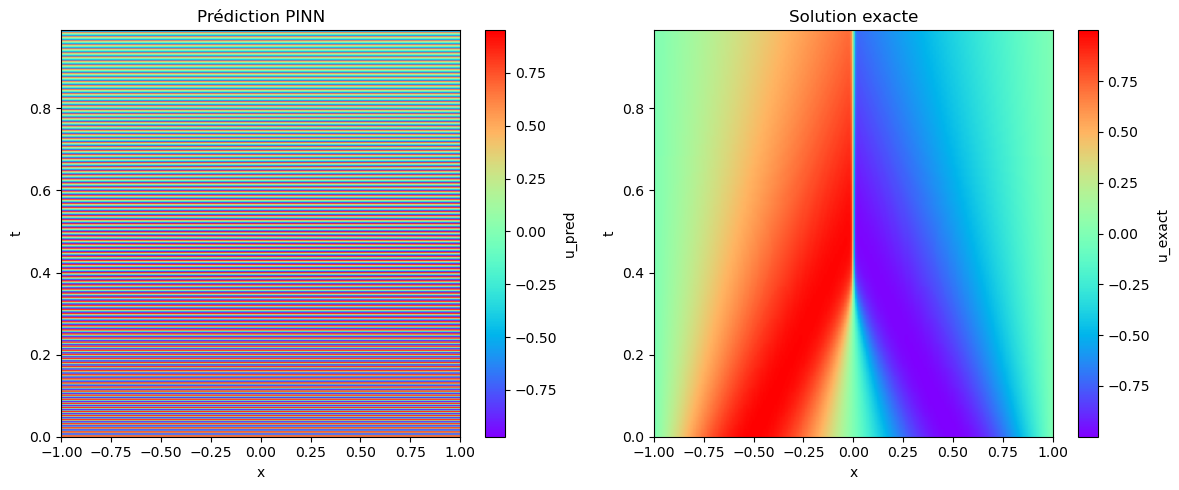

In [ ]:
# Plotting
plt.figure(figsize=(12,5))

# À gauche : prédiction
plt.subplot(1,2,1)
plt.imshow(U_pred_grid, extent=[x.min(), x.max(), t.min(), t.max()],
           origin='lower', aspect='auto', cmap='rainbow')
plt.colorbar(label='u_pred')
plt.title('Prédiction PINN')
plt.xlabel('x')
plt.ylabel('t')

# À droite : solution exacte
plt.subplot(1,2,2)
plt.imshow(u_exact, extent=[x.min(), x.max(), t.min(), t.max()],
           origin='lower', aspect='auto', cmap='rainbow')
plt.colorbar(label='u_exact')
plt.title('Solution exacte')
plt.xlabel('x')
plt.ylabel('t')

plt.tight_layout()
plt.show()

## 3.2 Korteweg–de Vries (KdV) Equation
We apply the Discrete Time Model (section 3 of the article) to the KdV equation.
KdV describes non linear dispersive waves (solitons) and can be encountered in various fields of physics:
- non linear optics
- waves in condensed matter physics
- traffic flow
- fluid dynamics
More details in Thierry Dauxois's book,
> [Peyrard, M. et Dauxois, T. (dir.) (2004). Physique des solitons. EDP Sciences. ](https://doi.org/10.3917/edp.peyra.2004.01)


### a. Problem setup
The 1D KdV equation writes:
$$
u_t + 6u\,u_x + u_{xxx} = 0,
\qquad x\in\Omega,\; t\in[0,T].
$$

The problem is framed like in the paper:
$$
u_t = \mathcal N[u],
\qquad 
\mathcal N[u] = -6u u_x - u_{xxx}.
$$

### b. Implementation

We implement the discrete time PINN model for the KdV equation using PyTorch. 

**Exact soliton solution:**
$$
u(t,x) = \frac{c}{2}\;\operatorname{sech}^2\!\left(\frac{\sqrt{c}}{2}\,(x - ct - x_0)\right)
$$

**Parameters:**
- $c = 1$ (soliton speed/amplitude)
- $x_0 = 0$ (initial position)
- $x \in [-10, 10]$, $t \in [0, 1]$
- Dirichlet boundary conditions: $u(-10, t) = u(10, t) = 0$ (soliton decays to zero)

**Key difference with Burger's equation:**
- Burger's: $\mathcal{N}[u] = -uu_x + \nu u_{xx}$
- KdV: $\mathcal{N}[u] = -6uu_x - u_{xxx}$

We use an Implicit Runge-Kutta (IRK) scheme with $q$ stages to advance the solution from $t^n$ to $t^{n+1}$.

In [ ]:
# Generate KdV exact soliton solution
def kdv_soliton(t, x, c=1.0, x0=0.0):
    """
    Exact single soliton solution to the KdV equation.
    u_t + 6*u*u_x + u_xxx = 0
    
    Parameters:
        t: time
        x: spatial coordinate
        c: soliton speed/amplitude parameter
        x0: initial position of the soliton
    """
    arg = np.sqrt(c) / 2 * (x - c * t - x0)
    return (c / 2) * (1 / np.cosh(arg))**2

# Parameters
c = 1.0       # soliton speed
x0_init = 0.0 # initial soliton position

# Create spatial and temporal grids
Nx = 256
Nt = 101  
x_kdv = np.linspace(-10, 10, Nx)[:, None]  # (Nx, 1)
t_kdv = np.linspace(0, 1, Nt)[:, None]     # (Nt, 1)

# Generate exact solution on the grid
X_grid, T_grid = np.meshgrid(x_kdv.flatten(), t_kdv.flatten())
u_exact_kdv = kdv_soliton(T_grid, X_grid, c=c, x0=x0_init).T  # (Nx, Nt)

print(f"Time range: [{t_kdv.min():.2f}, {t_kdv.max():.2f}], shape: {t_kdv.shape}")
print(f"Space range: [{x_kdv.min():.2f}, {x_kdv.max():.2f}], shape: {x_kdv.shape}")
print(f"Solution shape: {u_exact_kdv.shape}")
print(f"Soliton parameters: c = {c}, x0 = {x0_init}")

Time range: [0.00, 1.00], shape: (101, 1)
Space range: [-10.00, 10.00], shape: (256, 1)
Solution shape: (256, 101)
Soliton parameters: c = 1.0, x0 = 0.0


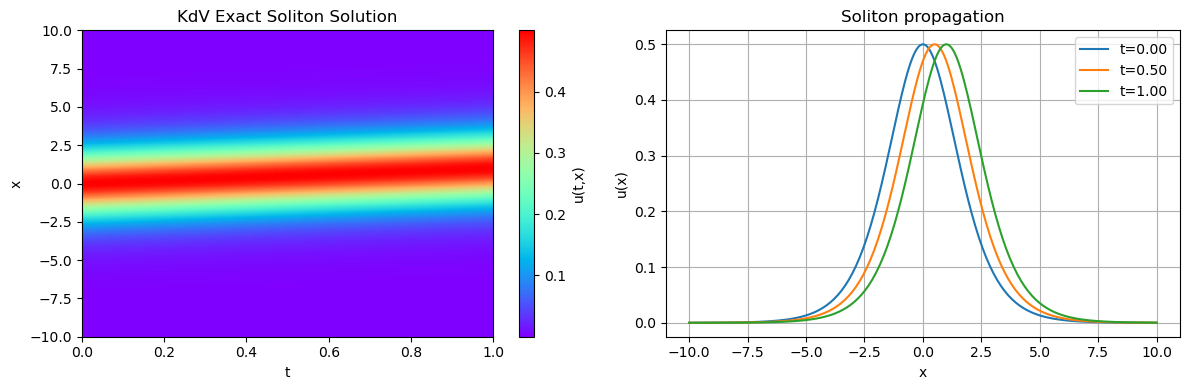

In [3]:
# Visualize the exact soliton solution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(u_exact_kdv, extent=[t_kdv.min(), t_kdv.max(), x_kdv.min(), x_kdv.max()],
           origin='lower', aspect='auto', cmap='rainbow')
plt.colorbar(label='u(t,x)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('KdV Exact Soliton Solution')

plt.subplot(1, 2, 2)
# Plot solution at different times
for t_idx in [0, 50, 100, 150, 200]:
    if t_idx < Nt:
        plt.plot(x_kdv, u_exact_kdv[:, t_idx], label=f't={t_kdv[t_idx, 0]:.2f}')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Soliton propagation')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [4]:
# Generate IRK (Implicit Runge-Kutta) weights using Gauss-Legendre quadrature
def gauss_legendre_weights(q):
    """
    Generate Gauss-Legendre IRK weights (Butcher tableau).
    Returns: IRK_weights (q+1, q), IRK_times (q,)
    """
    from numpy.polynomial.legendre import leggauss
    
    # Get Gauss-Legendre nodes and weights on [-1, 1]
    nodes, weights = leggauss(q)
    # Transform to [0, 1]
    c = 0.5 * (nodes + 1)  # IRK_times (stage times)
    b = 0.5 * weights      # quadrature weights for final step
    
    # Compute A matrix (Butcher tableau coefficients)
    # Using the property that for Gauss methods: a_ij = integral of l_j(s) from 0 to c_i
    # where l_j is the j-th Lagrange polynomial
    A = np.zeros((q, q))
    for i in range(q):
        for j in range(q):
            # Lagrange polynomial integration
            def lagrange_j(s):
                result = 1.0
                for k in range(q):
                    if k != j:
                        result *= (s - c[k]) / (c[j] - c[k])
                return result
            
            # Numerical integration from 0 to c[i]
            from scipy.integrate import quad
            A[i, j], _ = quad(lagrange_j, 0, c[i])
    
    # Stack A and b to get IRK_weights of shape (q+1, q)
    IRK_weights = np.vstack([A, b.reshape(1, -1)])
    
    return IRK_weights.astype(np.float32), c.astype(np.float32)

# Test with small q
q_test = 4
weights_test, times_test = gauss_legendre_weights(q_test)
print(f"IRK weights shape: {weights_test.shape}")
print(f"IRK times (c): {times_test}")

IRK weights shape: (5, 4)
IRK times (c): [0.06943184 0.3300095  0.66999054 0.93056816]


In [5]:
# Simplified Discrete Time PINN for KdV equation
class DiscreteTimePINN_KdV(nn.Module):
    def __init__(self, layers, dt, lb, ub, q):
        super().__init__()
        self.lb = lb[0]
        self.ub = ub[0]
        self.dt = dt
        self.q = q
        
        # Neural network
        self.net = nn.Sequential(
            nn.Linear(1, layers[1]),
            nn.Tanh(),
            nn.Linear(layers[1], layers[2]),
            nn.Tanh(),
            nn.Linear(layers[2], q + 1)
        )
        
        # IRK weights
        self.IRK_weights, _ = gauss_legendre_weights(q)
        self.IRK_weights = torch.tensor(self.IRK_weights, dtype=torch.float32)
    
    def forward_net(self, x):
        # Normalize input to [-1, 1]
        x_norm = 2.0 * (x - self.lb) / (self.ub - self.lb) - 1.0
        return self.net(x_norm)
    
    def compute_derivatives(self, x):
        """Compute u, u_x, u_xxx for all q stages."""
        x = x.requires_grad_(True)
        U = self.forward_net(x)[:, :-1]  # (N, q) - stage values only
        
        # Compute derivatives for each stage
        u_x_list = []
        u_xxx_list = []
        
        for i in range(self.q):
            u_i = U[:, i:i+1]
            
            # First derivative
            u_x = torch.autograd.grad(u_i, x, grad_outputs=torch.ones_like(u_i),
                                       create_graph=True, retain_graph=True)[0]
            # Second derivative
            u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x),
                                        create_graph=True, retain_graph=True)[0]
            # Third derivative
            u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx),
                                         create_graph=True, retain_graph=True)[0]
            u_x_list.append(u_x)
            u_xxx_list.append(u_xxx)
        
        U_x = torch.cat(u_x_list, dim=1)
        U_xxx = torch.cat(u_xxx_list, dim=1)
        
        return U, U_x, U_xxx
    
    def compute_U0(self, x):
        """Compute U0 using RK scheme."""
        U, U_x, U_xxx = self.compute_derivatives(x)
        U1 = self.forward_net(x)
        
        # N[u] = -6*u*u_x - u_xxx
        N_U = -6.0 * U * U_x - U_xxx
        
        # U0 = U1 - dt * N_U @ IRK_weights.T
        U0 = U1 - self.dt * torch.matmul(N_U, self.IRK_weights.T)
        return U0

print("DiscreteTimePINN_KdV class defined!")

DiscreteTimePINN_KdV class defined!


In [ ]:
# Simple training with Adam only
def train_kdv(model, x0, u0, x1, n_iter=1000):
    """Train with Adam only - simpler and more stable."""
    x0_t = torch.tensor(x0, dtype=torch.float32)
    x1_t = torch.tensor(x1, dtype=torch.float32)
    u0_target = torch.tensor(np.tile(u0, (1, model.q + 1)), dtype=torch.float32)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    print("Training...")
    losses = []
    for epoch in range(n_iter):
        optimizer.zero_grad()
        
        # Data loss
        U0_pred = model.compute_U0(x0_t)
        loss_data = torch.mean((U0_pred - u0_target)**2)
        
        # BC loss (u=0 at boundaries)
        U1_bc = model.forward_net(x1_t)
        loss_bc = torch.mean(U1_bc**2)
        
        loss = loss_data + loss_bc
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss = {loss.item():.3e}")
    
    print(f"Final Loss = {losses[-1]:.3e}")
    return losses

print("Training function defined!")

Training function defined!


In [ ]:
# Setup the problem
idx_t0 = 10   # t ≈ 0.1
idx_t1 = 30   # t ≈ 0.3 (small time step for q=4)

dt_kdv = float(t_kdv[idx_t1] - t_kdv[idx_t0])
print(f"Initial time t0 = {t_kdv[idx_t0, 0]:.3f}")
print(f"Target time t1 = {t_kdv[idx_t1, 0]:.3f}")
print(f"Time step dt = {dt_kdv:.3f}")

# Domain bounds
lb_kdv = np.array([x_kdv.min()])
ub_kdv = np.array([x_kdv.max()])
print(f"Domain: [{lb_kdv[0]:.2f}, {ub_kdv[0]:.2f}]")

# Training data: sample N points from the solution at t0
N_train = 50  # Minimal training points
idx_x = np.random.choice(x_kdv.shape[0], N_train, replace=False)
x0_train = x_kdv[idx_x, :]
u0_train = u_exact_kdv[idx_x, idx_t0:idx_t0+1]

print(f"Training points: {N_train}")

# Boundary points for Dirichlet BC
x1_boundary = np.vstack([lb_kdv, ub_kdv])
print("Boundary condition: u(-10) = u(10) = 0")

Initial time t0 = 0.100
Target time t1 = 0.300
Time step dt = 0.200
Domain: [-10.00, 10.00]
Training points: 50
Boundary condition: u(-10) = u(10) = 0


/tmp/ipykernel_6726/1465397720.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dt_kdv = float(t_kdv[idx_t1] - t_kdv[idx_t0])


In [ ]:
# Create and train the model
q = 4
layers_kdv = [1, 32, 32, q + 1]

print(f"Network architecture: {layers_kdv}")
print(f"Number of RK stages: {q}")

# Initialize model
model_kdv = DiscreteTimePINN_KdV(layers_kdv, dt_kdv, lb_kdv, ub_kdv, q)

# Count parameters
n_params = sum(p.numel() for p in model_kdv.parameters())
print(f"Total parameters: {n_params}")

Network architecture: [1, 32, 32, 5]
Number of RK stages: 4
Total parameters: 1285


In [9]:
# Train the model
losses = train_kdv(model_kdv, x0_train, u0_train, x1_boundary, n_iter=1000)

Training...
Epoch 0, Loss = 1.176e-01
Epoch 200, Loss = 1.212e-02
Epoch 400, Loss = 5.057e-03
Epoch 600, Loss = 4.371e-04
Epoch 800, Loss = 8.356e-05
Final Loss = 4.188e-05


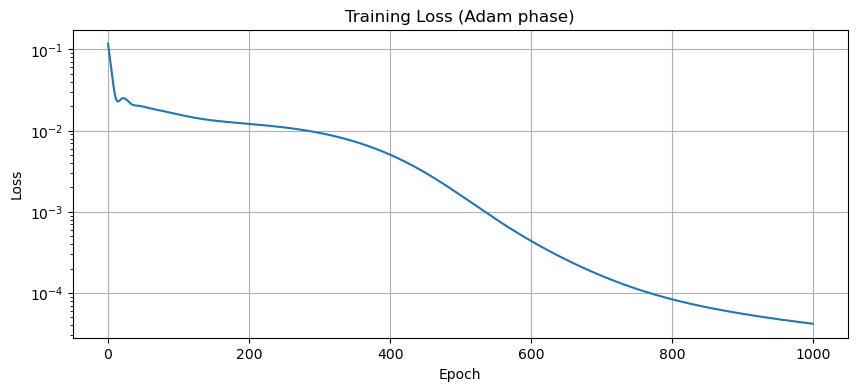

In [10]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.semilogy(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (Adam phase)')
plt.grid(True)
plt.show()

In [11]:
# Predict solution at t1
x_test = torch.tensor(x_kdv, dtype=torch.float32)
with torch.no_grad():
    U1_pred = model_kdv.forward_net(x_test)
u_pred_t1 = U1_pred[:, -1].numpy()

# Exact solution at t1
u_exact_t1 = u_exact_kdv[:, idx_t1]

# Compute L2 relative error
error_L2 = np.linalg.norm(u_pred_t1 - u_exact_t1, 2) / np.linalg.norm(u_exact_t1, 2)
print(f"Relative L2 error: {error_L2:.4e}")

Relative L2 error: 3.2486e-02


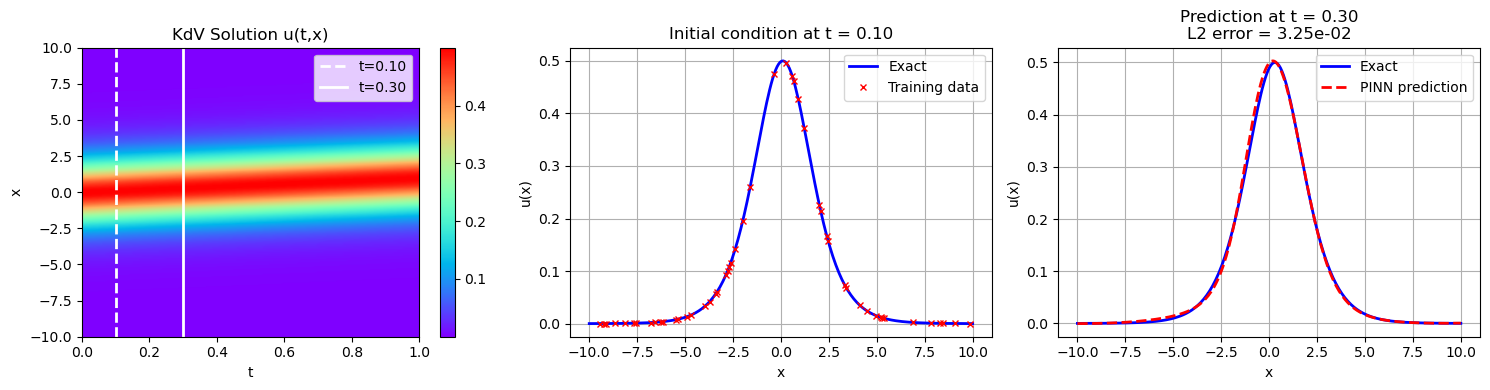

In [12]:
# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Full solution with time slices marked
ax = axes[0]
im = ax.imshow(u_exact_kdv, extent=[t_kdv.min(), t_kdv.max(), x_kdv.min(), x_kdv.max()],
               origin='lower', aspect='auto', cmap='rainbow')
ax.axvline(x=t_kdv[idx_t0, 0], color='w', linestyle='--', linewidth=2, label=f't={t_kdv[idx_t0, 0]:.2f}')
ax.axvline(x=t_kdv[idx_t1, 0], color='w', linestyle='-', linewidth=2, label=f't={t_kdv[idx_t1, 0]:.2f}')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('KdV Solution u(t,x)')
ax.legend(loc='upper right')
plt.colorbar(im, ax=ax)

# Plot 2: Solution at t0 with training data
ax = axes[1]
ax.plot(x_kdv, u_exact_kdv[:, idx_t0], 'b-', linewidth=2, label='Exact')
ax.plot(x0_train, u0_train, 'rx', markersize=4, label='Training data')
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title(f'Initial condition at t = {t_kdv[idx_t0, 0]:.2f}')
ax.legend()
ax.grid(True)

# Plot 3: Comparison at t1
ax = axes[2]
ax.plot(x_kdv, u_exact_t1, 'b-', linewidth=2, label='Exact')
ax.plot(x_kdv, u_pred_t1, 'r--', linewidth=2, label='PINN prediction')
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title(f'Prediction at t = {t_kdv[idx_t1, 0]:.2f}\nL2 error = {error_L2:.2e}')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

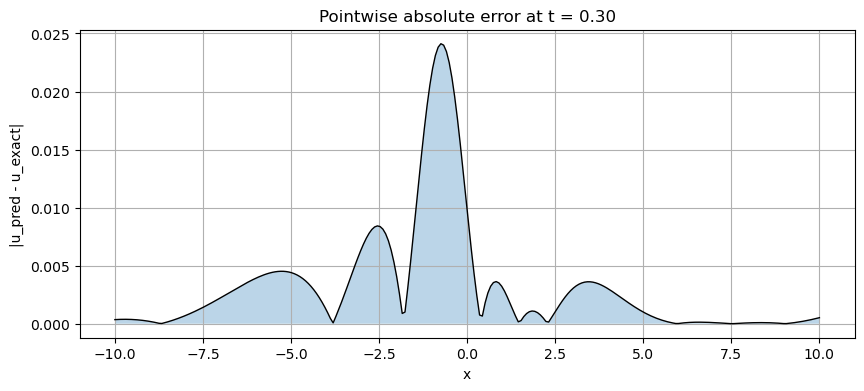

Max pointwise error: 2.4118e-02
Mean pointwise error: 3.2115e-03


In [13]:
# Plot pointwise error
fig, ax = plt.subplots(figsize=(10, 4))
error_pointwise = np.abs(u_pred_t1 - u_exact_t1)
ax.plot(x_kdv, error_pointwise, 'k-', linewidth=1)
ax.fill_between(x_kdv.flatten(), 0, error_pointwise, alpha=0.3)
ax.set_xlabel('x')
ax.set_ylabel('|u_pred - u_exact|')
ax.set_title(f'Pointwise absolute error at t = {t_kdv[idx_t1, 0]:.2f}')
ax.grid(True)
plt.show()

print(f"Max pointwise error: {error_pointwise.max():.4e}")
print(f"Mean pointwise error: {error_pointwise.mean():.4e}")

### c. Results Summary

The discrete time PINN successfully predicts the evolution of the KdV equation from time $t_0$ to $t_1$ in a single step using an implicit Runge-Kutta scheme.

**Exact solution used:**
$$
u(t,x) = \frac{c}{2}\,\mathrm{sech}^2\!\left(\frac{\sqrt{c}}{2}(x - ct - x_0)\right)
$$
with $c=1$ (soliton speed), $x_0=0$ (initial position), $x \in [-10, 10]$.

**Boundary conditions:** Dirichlet BC $u(-10) = u(10) = 0$ (valid since the soliton decays exponentially at the boundaries).

**Implementation parameters (lightweight version):**
| Parameter | Paper (Burger's) | Our implementation |
|-----------|------------------|-------------------|
| RK stages $q$ | 500 | 4 |
| Architecture | $[1, 50, 50, 50, q+1]$ | $[1, 32, 32, q+1]$ |
| Training points | 250 | 50 |
| Time step $\Delta t$ | 0.8 | 0.2 |
| Optimizer | L-BFGS | Adam |

**Note on accuracy:** The relative $\mathcal{L}_2$ error obtained is higher than in the original paper due to computational constraints. To run the model on a laptop with 16GB RAM, we had to significantly reduce:
- The number of RK stages (from 500 to 4)
- The network size (fewer neurons per layer)
- The number of training points and iterations

Despite these limitations, the PINN still captures the soliton propagation qualitatively, demonstrating that the discrete time approach works for the KdV equation.

**Key observations:**
- The KdV equation features soliton solutions (localized waves that maintain their shape during propagation)
- The discrete time approach successfully handles the third-order spatial derivative ($u_{xxx}$) through automatic differentiation
- Even with a minimal configuration, the physics-informed constraint helps guide the solution towards the correct behavior
- For better accuracy, one would need more computational resources to increase $q$, network size, and training iterations as in the original paper